<a href="https://colab.research.google.com/github/ndtuan10/Nhan-dang-CS338.L22.KHCL/blob/main/BaiTap/Handwritten_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bài tập 1**
# **Ngô Đức Tuấn**
MSSV: 18520186

- Nhận dạng chữ số viết tay (Handwritten)_MNIST bằng CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Thư viện được sử dụng
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
from sklearn import metrics
from sklearn.metrics import accuracy_score
from keras import Model
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
print('''
  Phiên bản của các thư viện :
    + Tensorflow : {0}
    + keras : {1}
    + numpy : {2}
    + matplotlib : {3}
    + pandas : {4}
'''.format(tf.__version__, keras.__version__, np.__version__, matplotlib.__version__, pd.__version__))


  Phiên bản của các thư viện :
    + Tensorflow : 2.4.1
    + keras : 2.4.0
    + numpy : 1.19.5
    + matplotlib : 3.2.2
    + pandas : 1.1.5



#**1.Giới thiệu về Dataset MNIST**
 Dataset sử dụng về phân loại chữ số viết tay (Handwritten digit classification) từ **MNIST**, chứa khoảng 60.000 ảnh được dùng để train và 10.000 ảnh được dùng để test phân thành 10 loại (tương ứng nhãn từ chữ 0 đến 9).  Độ phân giải thấp (28 by 28 pixels = 784 pixels), như hình minh hoạ bên dưới:


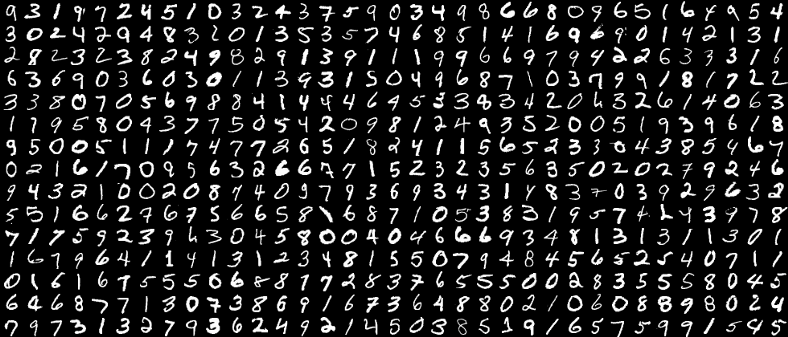




Ta sẽ load dataset trực tiếp từ chính thư viện [keras](https://keras.io/api/datasets/mnist/) đã được tích hợp sẵn.

Tuy nhiên, trong bài này em sẽ load data bằng 2 file .csv là `train_new.csv` và `test_new.csv` được chia sẻ trên drive của trang submission.

# **2. Thiết lập mô hình mạng Lenet**

In [ ]:
class LeNet:
  # khởi tạo 1 số tham số chính của mô hình  
  def __init__(self):
    self.model = None

  # Xây dựng kiến trúc cho mạng
  def build(self, input_dim):
    input = Input(shape=input_dim)

    # Tầng 2D Convolution + Tầng activation (ReLU) + Tầng Pooling
    C1 = Conv2D(32, (4, 4), padding="same", activation='relu', use_bias=True)(input) #input_dim = (28,28,1)
    S1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(C1) #sử dụng thủ tục max-pooling
    C2 = Conv2D(64, (3,3), padding="same", activation='relu', use_bias=True)(S1)
    S2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(C2) #sử dụng thủ tục max-pooling

    # Tầng Fully Connected
    flat = Flatten()(S2)
    FC2 = Dense(50, activation='relu', use_bias=True)(flat)
    output = Dense(10, activation='softmax', use_bias=True)(FC2) #10 neuron tượng trưng 10 giá trị output, hàm activation ở output là softmax

    # Biên dịch mô hình (*ghi chú bên dưới*)
    self.model = Model(input, output)
    self.model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
  
  # Phương thức để đưa dữ liệu vào và huấn luyện
  def train(self, x_train, y_train):
    history = self.model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), verbose=1)
    return history

  # Đánh giá trên tập test
  def evaluate(self, x_test, y_test):
    (eval_loss, eval_accuracy) = self.model.evaluate(x_test, y_test, batch_size = 128, verbose=1)
    return (eval_loss, eval_accuracy)

  # dự đoán mô hình
  def predict(self, test):
    return self.model.predict(test)

  # giúp debug và in ra kiến trúc của mô hình  
  def summary(self):
    self.model.summary()

  # load mô hình từ file
  def load(self, model_file):
    self.model = load_model(model_file)

  # lưu mô hình xuống file
  def save(self, model_file):
    self.model.save(model_file)

### Biên dịch mô hình

Trước khi mô hình có thể được huấn luyện, chúng ta cần thêm các hàm toán học giúp cho việc đánh giá hay làm mô hình đi " đúng hướng ". Các chỉnh sửa này được thêm vào trong bước *biên dịch* của mô hình:

* *Hàm mất mát* — dùng để tính toán "độ sai sót" của mô hình trong quá trình huấn luyện và dự đoán. Chúng ta cần phải làm cho nghiệm của hàm này nhỏ nhất để kiểm soát mô hình đi đúng hướng. (mất mát càng ít, chính xác càng cao). *Hàm mất mát* hay *loss function* được sử dụng là `crossentropy`.
* *Hàm tối ưu* — Đây là "công cụ" để làm hàm mất mát có nghiệm nhỏ nhất, qua việc cập nhật và chỉnh sửa các tham số có trong hàm mất mát. *Hàm tối ưu* hay *optimizier function* được sử dụng là `Stochastic Gradient Descent (SGD)`.
* *Thang đo* — dùng để đo đạc độ chính xác qua mỗi quá trình huấn luyện và kiểm tra. Chúng ta sẽ sử dụng phép đo `accuracy`, nhằm nắm được tỉ lệ ảnh được phân loại chính xác.

# **3. Xử lí dataset**

In [ ]:
PATH_DIR = '/content/drive/My Drive/Nhận dạng/Handwritten/'
TRAIN_PATH = PATH_DIR + 'train_new.csv'
TEST_PATH = PATH_DIR + 'test_new.csv'

In [ ]:
# load dữ liệu train
train = pd.read_csv(TRAIN_PATH)
print(train.shape)
train.head()   

(29400, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- Kích thước của tập train là (29400, 785) tương ứng số lượng dữ liệu là 29400, số lượng cột là 785 cột (784 cột ứng với 28*28 = 784 pixels nhận được trong khoảng từ 0-255 và 1 cột `label` chứa thông tin nhãn chữ số)

In [ ]:
# load dữ liệu test
test = pd.read_csv(TEST_PATH)
print(test.shape)
test.head()   

(12600, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- Tương tự với tập test là (12600, 784), 12600 tương ứng số lượng dữ liệu 12600, số lượng cột là 784 vì bỏ đi cột `label`. 

# **4. Tổng quan về dữ liệu**

In [ ]:
# Xem số kích thước bộ dữ liệu
print("Kích thước của bộ dữ liệu train là: ", len(train))
print("Kích thước của bộ dữ liệu test là: ", len(test))

# Xem các đặc trưng
print(train.columns)

Kích thước của bộ dữ liệu train là:  29400
Kích thước của bộ dữ liệu test là:  12600
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


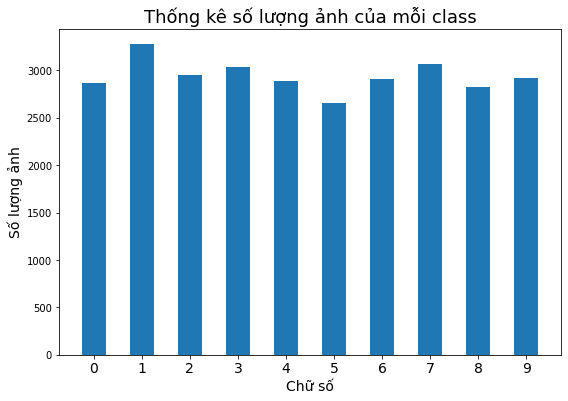

In [ ]:
# Xem phân bố nhãn 
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counts = [0]*10

for i in range(0, len(train)):
    index = train['label'].values[i]
    counts[index] += 1
    
fig, ax = plt.subplots(figsize=(9,6))

ax.bar(digits, counts, width=0.5)

ax.set_title('Thống kê số lượng ảnh của mỗi class', fontsize=18)
ax.set_xlabel('Chữ số', fontsize=14)
ax.set_ylabel('Số lượng ảnh', fontsize=14)

plt.xticks(digits, fontsize=14)

plt.show()

In [ ]:
 # mean = giá trị trung bình, std = độ lệch chuẩn = căn bậc hai của phương sai.
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,29400.000000,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.000000,29400.000000,29400.000000,29400.000000,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,...,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.0,29400.0,29400.0,29400.0,29400.0
mean,4.453810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004286,0.015986,0.007347,0.000306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002959,0.015952,0.062245,0.080204,0.137483,...,3.864252,2.789490,1.755782,1.073810,0.573469,0.238980,0.096939,0.025544,0.000170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008776,0.042721,0.082585,0.111871,0.175136,0.300306,0.435000,0.543401,0.546667,0.681190,0.616429,0.481599,0.291395,0.179592,0.111429,0.059762,0.021565,0.002449,0.0,0.0,0.0,0.0,0.0
std,2.882268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.679033,1.944539,1.259738,0.052489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495867,1.605434,3.598257,3.579551,5.279914,...,27.353457,22.956181,18.338453,14.252952,10.589347,6.479777,4.130840,2.014572,0.029161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.135228,2.681554,4.004222,4.440134,5.676486,7.054336,9.258972,10.289716,9.903889,11.375302,10.793327,9.476717,7.071690,5.691586,4.603814,3.291418,1.999050,0.318581,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

- Để có thể đưa vào mô hình Lenet để huấn luyện, ta cần phải reshape về dạng kích thước (28,28). 

In [ ]:
# reshape kích thước tập train, test
X_train = train.iloc[:, 1:]
Y_train = train.iloc[:, 0]
train_images = X_train.values.reshape(-1,28,28)
test_images = test.values.reshape(-1,28,28)

print(train_images.shape)
print(test_images.shape)

(29400, 28, 28)
(12600, 28, 28)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
binencoder = LabelBinarizer()
Y_train = binencoder.fit_transform(Y_train)
Y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

# **5. Tách dữ liệu train-test (Train-test-split)**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_images, Y_train, test_size = 0.2, random_state=90)

# **6. Khai phá dữ liệu**

In [ ]:
# Khai phá dữ liệu 
print('x_train: {}, y_train: {}, x_test: {}, y_test: {}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train: (23520, 28, 28), y_train: (23520, 10), x_test: (5880, 28, 28), y_test: (5880, 10)


In [ ]:
result = {
    'Data':["x_train", "y_train", "x_test", "y_test"],
    'Shape': [x_train.shape, y_train.shape, x_test.shape, y_test.shape]
}
pd.DataFrame(result)

,Data,Shape
0,x_train,"(23520, 28, 28)"
1,y_train,"(23520, 10)"
2,x_test,"(5880, 28, 28)"
3,y_test,"(5880, 10)"


# **7. Tiền xử lý dữ liệu**

In [ ]:
# Chuẩn hóa dữ liệu
x_train = x_train / 255.0 
x_test = x_test / 255.0 

x_train = x_train.reshape(-1,28,28,1).astype('float32')
x_test = x_test.reshape(-1,28,28,1).astype('float32')

In [ ]:
test_images = test_images/255.0

test = test_images.reshape(-1,28,28,1).astype('float32')

# **8. Train mô hình và đánh giá trên tập test**

In [ ]:
leNet = LeNet()
leNet.build((28,28,1))
leNet.summary()
hist = leNet.train(x_train, y_train)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                156850

Trong quá trình huấn luyện, các số liệu mất mát và chính xác được liệt kê trong từng quá trình lặp (epoch). Ở đây, ta lấy số epochs = 30 vì lặp càng cao, kết quả càng chính xác. Sau khi quan sát tới lần lặp cuối cùng, ta thấy độ chính xác là khá cao dao động ở mức 98%.

In [ ]:
(eval_loss, eval_accuracy) = leNet.evaluate(x_test, y_test)
print('Độ chính xác của mô hình là: {:.2f}%'.format(eval_accuracy*100))

46/46 [==============================] - 1s 31ms/step - loss: 0.0826 - accuracy: 0.9753
Độ chính xác của mô hình là: 97.53%


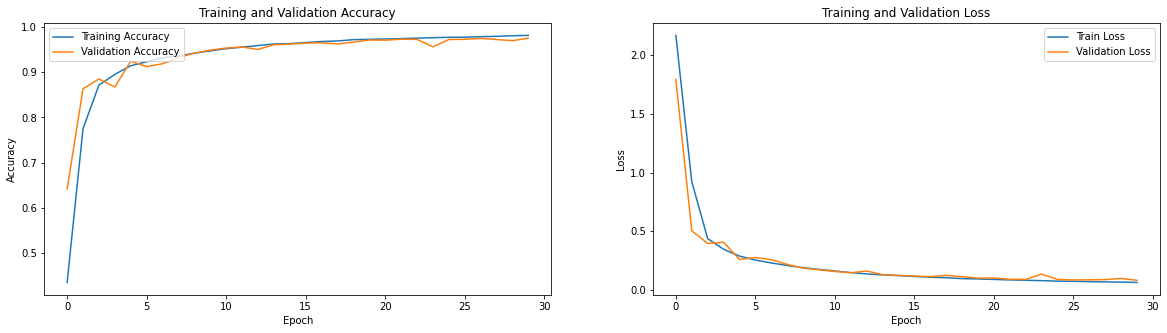

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()


Overfitting xảy ra khi một mô hình máy học hoạt động cực kì chính xác trên dữ liệu huấn luyện nhưng lại rất kém khi được cung cấp các dữ liệu vào mới, tức dữ liệu mà mô hình chưa từng "thấy" trước đây.

Qua 2 biểu đồ trên, ta nhận thấy sự khác biệt trong tỷ lệ chính xác và mất 
mát giữa 2 tập dữ liệu là không quá cao. Do vậy, hiện tượng quá khớp ( Overfitting) không xảy ra.

### Chạy trên dữ liệu tập test

In [ ]:
test_pred = leNet.predict(test)

# **9. Submit lên hệ thống**

In [ ]:
submit = pd.DataFrame(np.argmax(test_pred, axis=1), 
                      columns=['Label'], 
                      index=pd.read_csv('/content/drive/My Drive/Nhận dạng/Handwritten/sample_submission_new.csv')['ImageId'])

In [ ]:
submit.index.name = 'ImageId'
submit.to_csv('submission.csv')
submit

,Label
ImageId,
1,3
2,2
3,7
4,6
5,6
...,...
12596,0
12597,1
12598,7


- Kết quả trên hệ thống submission:
    - Best Score: 0.97587
    - Rank: 27/156

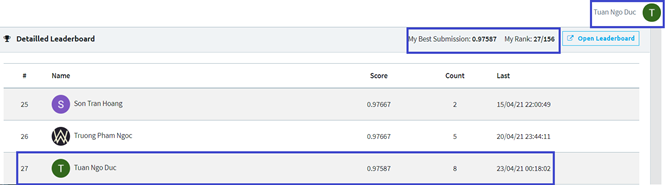
